# Test the trained agent & Compare value estimates

In [13]:
import numpy as np
from numpy import arctan
import gym
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ddpg_agent import DDPGAgent
from utils import get_th, obs2state

In [4]:
env = gym.make('Pendulum-v0')
obs_dim, act_dim = env.observation_space.shape[0], env.action_space.shape[0]
max_ep_len = env._max_episode_steps

print('observation space dimension /action space dimension : {} / {}'.format(obs_dim, act_dim))
print('episode length : {}'.format(max_ep_len))

observation space dimension /action space dimension : 3 / 1
episode length : 200


In [5]:
agent = DDPGAgent(obs_dim, act_dim, hidden_size1=64, hidden_size2=64)
agent.load_model('./checkpoints/Pendulum-v0/DDPG(iter=100000)model.pth.tar')

In [6]:
obs = env.reset()
score = 0.
done = False

while not done:
    
    env.render()
    action = agent.get_action(obs, eval=True)
    obs, reward, done, info = env.step(action)
    score += reward
    
env.close()
print('score : {}'.format(score))

score : -121.14963805745984


## Monte-Carlo estimate vs Critic estimate

To recap, once we learn the optimal Q-function and the optimal policy $\pi^\star$, the optimal value $V(s)$ can be computed by
\begin{equation*}
V(s) = Q(s, \pi^\star(s)).
\end{equation*}
On the other hand, suppose that $\pi^\star$ is an optimal policy, then $V(s)$ is given by
\begin{equation*}
V(s) = \mathbb{E}^{\pi^\star} \left( \sum_{t=0}^\infty \gamma^t r_t \right).
\end{equation*}
Now, let's assume that our DDPG agent successfully learn $\pi^\star$(from simulation, it seems to truly happen!). To see whether overestimation exists, we might compare value function estimated from both methods addressed above.

In [9]:
N = 10000
mc_estimates = np.zeros(N)
obs_arr = np.zeros(shape = (N, obs_dim))

for i in range(N):
    # compute Monte-Carlo estimates of the value function $V^\pi$
    
    score = 0.
    obs = env.reset()
    obs_arr[i] = obs
    for t in range(max_ep_len):
        action = agent.get_action(obs, eval=True)
        obs, reward, done, info = env.step(action)
        score += reward
    if i % 1000 == 0:
        print('{} episodes collected'.format(i))
    mc_estimates[i] = score

0 episodes collected
1000 episodes collected
2000 episodes collected
3000 episodes collected
4000 episodes collected
5000 episodes collected
6000 episodes collected
7000 episodes collected
8000 episodes collected
9000 episodes collected


In [10]:
obs_tensor = torch.tensor(obs_arr, dtype=torch.float)
with torch.no_grad():
    q_tensor = agent.Q(obs_tensor, agent.pi(obs_tensor))
critic_estimates = np.squeeze(q_tensor.numpy())


state_arr = np.zeros(shape=(N, 2))
for i in range(N):
    state_arr[i] = obs2state(obs_arr[i])

In [11]:
th, th_dot = state_arr[:, 0], state_arr[:, 1]

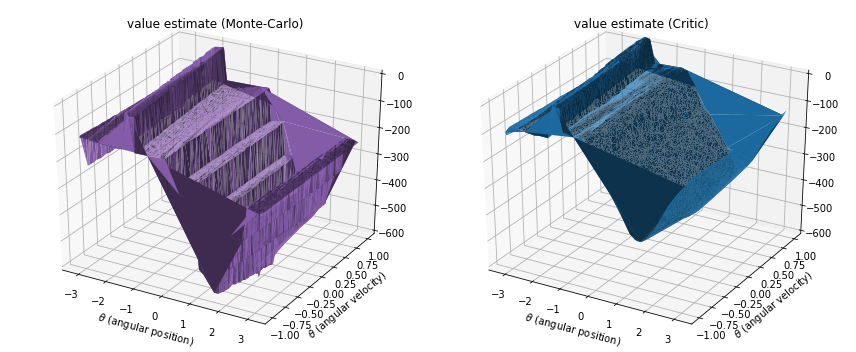

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(th, th_dot, mc_estimates, color='tab:purple')
ax.set_title('value estimate (Monte-Carlo)')
ax.set_xlabel(r'$\theta$ (angular position)')
ax.set_ylabel(r'$\dot\theta$ (angular velocity)')
ax.set_zlim(-600., 0.)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(th, th_dot, critic_estimates, color='tab:blue')
ax.set_title('value estimate (Critic)')
ax.set_xlabel(r'$\theta$ (angular position)')
ax.set_ylabel(r'$\dot\theta$ (angular velocity)')
ax.set_zlim(-600., 0.)
fig.tight_layout()
fig.savefig('value.png')

/home/sju5379/anaconda3/envs/drl/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


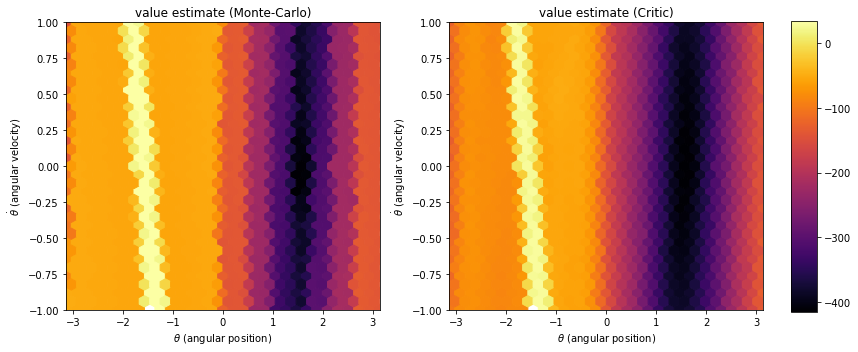

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

im = ax[0].hexbin(th, th_dot, C=mc_estimates, cmap='inferno', bins=None, gridsize=30)
ax[0].set_title('value estimate (Monte-Carlo)')
ax[0].set_xlabel(r'$\theta$ (angular position)')
ax[0].set_ylabel(r'$\dot\theta$ (angular velocity)')
ax[0].set_xlim(-np.pi, np.pi)
ax[0].set_ylim(-1., 1.)


im = ax[1].hexbin(th, th_dot, C=critic_estimates, cmap='inferno', bins=None, gridsize=30)
ax[1].set_title('value estimate (Critic)')
ax[1].set_xlabel(r'$\theta$ (angular position)')
ax[1].set_ylabel(r'$\dot\theta$ (angular velocity)')
ax[1].set_xlim(-np.pi, np.pi)
ax[1].set_ylim(-1., 1.)
cax = fig.add_axes([.92, 0.12, 0.03, 0.81]) 
fig.colorbar(im, cax =cax, use_gridspec=True)
fig.tight_layout(rect=[0, 0, 0.9, 1.])

fig.savefig('value_heatmap.png')